# Proyecto: El Desafío de Don Rene

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Pablo Badilla
- Auxiliar: Ignacio Meza D.
- Ayudante: Constanza Peña

### Equipo:

- Nombre de alumno 1: Rafael De La Sotta
- Nombre de alumno 2: Andrés Medina

- rafadls

- \<Nombre del Equipo en Codalab\>

### Link de repositorio de GitHub: `https://github.com/rafadls/LPC/tree/feature/Proyecto`

## Funciones

In [1]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from scipy import stats

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

import seaborn as sns

import warnings
warnings.simplefilter("ignore")

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Pre-procesamiento
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# Librería para NLP
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize  
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

# Clasifación
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Regression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

# GridSearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from pandas.api.types import is_numeric_dtype
from pandas.core.dtypes.common import is_datetime_or_timedelta_dtype


def profile_serie(serie_in, n_samples=1000, random_state=42):
    serie = serie_in.copy()

    profile = pd.Series(dtype='object')
    profile["Type"] = serie.dtype
    profile = pd.concat([profile, serie.describe(datetime_is_numeric=True)])

    # profile = pd.Series([])

    if is_numeric_dtype(serie):
        profile["Negative"] = (serie < 0).sum()
        profile["Negative (%)"] = (
            str(round((serie < 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Zeros"] = (serie == 0).sum()
        profile["Zeros (%)"] = (
            str(round((serie == 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Kurt"] = serie.kurt()
        profile["Skew"] = serie.skew()

    profile[" "] = " "  # espacio

    profile["Missing cells"] = serie.isnull().sum()
    profile["Missing cells (%)"] = (
        str(round(serie.isnull().sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Duplicate rows"] = serie.duplicated(False).sum()
    profile["Duplicate rows (%)"] = (
        str(round(serie.duplicated(False).sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Total size in memory"] = str(serie.memory_usage(index=True)) + " bytes"

    # profile = pd.concat([profile, description])

    profile = profile.rename(
        index={
            "count": "Number of observations",
            "mean": "Mean",
            "std": "Std",
            "min": "Min",
            "max": "Max",
            "unique": "Unique",
            "top": "Top",
            "freq": "Freq",
        }
    )
    no_outliers_fig = None

    if is_numeric_dtype(serie):

        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(
            sampled_serie, marginal="box", title=f"{serie.name} - With Outliers"
        )

        no_outliers = sampled_serie.loc[(np.abs(stats.zscore(sampled_serie)) < 3)]
        # zscore = https://es.wikipedia.org/wiki/Unidad_tipificada
        
        no_outliers_fig = px.histogram(
            no_outliers, marginal="box", title=f"{serie.name} - Without Outliers"
        )

    elif is_datetime_or_timedelta_dtype(serie):
        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(sampled_serie, marginal="box", title=f"{serie.name}")
    
    else:
        count = (
            serie.value_counts()[0:100]
            .reset_index()
            .rename(columns={"index": serie.name, serie.name: "Count"})
        )
        fig = px.bar(
            x=count[serie.name].astype(str),
            y=count["Count"],
            title=f"100 Most common categories of {serie.name}",
        )
    display(Markdown(f'## {serie.name} Profile'))
    display(profile)
    fig.show()

    if no_outliers_fig:
        no_outliers_fig.show()

    # return fig, profile

In [3]:
def custom_features(dataframe_in):
    dataframe_in = dataframe_in[['english','platforms', 'required_age', 'categories', 'genres','achievements', 'average_playtime', 'price']]
    return split_hot_encoding(dataframe_in, ['platforms','categories','genres'])

In [4]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.min = np.min(X,axis=0)
        self.max = np.max(X,axis=0)
        return self
    
    def transform(self, X):
        if (self.max == self.min).any():
            return X
        else:
            return (X - self.min)/(self.max - self.min)

In [5]:
def split_hot_encoding(df, columns):
    for column in columns:    
        df = pd.concat([df, df[column].str.split(';').str.join('|').str.get_dummies()], axis=1)
        df = df.drop(columns=[column])
    return df

In [6]:
# Definimos algunas stopword que queremos que sean eliminadas
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend([','])

# Definimos un tokenizador con Stemming
class StemmerTokenizer:
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in stop_words]
        return [self.ps.stem(t) for t in doc_tok]

# Inicializamos tokenizador
tokenizador = StemmerTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Introducción

El objetivo de este proyecto consiste en crear un modelo que reciba las características de un nuevo videojuego e indique si este será potencialmente una inversión rentable o no. Para medir el éxito de un juego se tiene la evaluación de los usuarios y las ventas. 

Los datos que proveen es un dataset con 7881 ejemplos que describen una observación de un videojuego. Cada videojuego cuenta con 16 atributos: 

- **Datos del juego:** name, release_date, english, developer, publisher, platforms, required_age, categories, genres, tags, achievements, average_playtime, price, short_description.
- **Variables a predecir:** estimated_sells, rating

Los datos del juego son la entrada a cada uno de estos modelos. A continuación se decribe cada uno de estos.

- **name                   (string)**: Corresponde al nombre del juego
- **release_date           (Date)**: Fecha de estreno
- **english                 (bool)**: Si está en inglés o no
- **developer              (string)**: Nombre de los desarrolladores responsables del juego
- **publisher              (string)**: Nombre de los publicistas responsables del juego
- **platforms              (string)**: Plataformas donde el juego puede ser jugado
- **required_age            (int)**: Edad mínima para jugar este juego
- **categories             (string)**: Categorias a las que pertenece el juego
- **genres                 (string)**: Géneros a los que pertenece el juego
- **tags                   (string)**: Temáticas que se incluyen en el juego
- **achievements            (int)**: Cantidad de logros o metas disponibles dentro del juego
- **average_playtime        (int)**: Tiempo promedio de juego (minutos)
- **price                 (float)**: Precio del juego
- **short_description      (string)**: Breve descripción del juego

Por su parte, exiten dos datos de salida, y para obtenerlos se crean dos modelos distintos, uno de clasificación y otro de regresión.

- **estimated_sells         (int)**: Número estimado de juegos vendidos. Este es el valor que busca predecir el modelo de regresión.
- **rating               (category)**: Evaluación hecha por el público. Este es el valor que busca predecir el modelo de clasificación. 

---
## 2. Análisis Exploratorio de Datos

In [7]:
df_train = pd.read_pickle('train.pickle')

In [8]:
df_train.head(3)

name release_date  english                     developer  \
0      An Aspie Life   2018-03-29        1  Bradley Hennessey;Joe Watson   
1  GhostControl Inc.   2014-06-06        1                     bumblebee   
2            Deponia   2012-08-06        1        Daedalic Entertainment   

                        publisher          platforms  required_age  \
0               EnderLost Studios            windows             0   
1  Application Systems Heidelberg  windows;mac;linux             0   
2          Daedalic Entertainment  windows;mac;linux             0   

                                          categories  \
0                   Single-player;Steam Achievements   
1  Single-player;Steam Achievements;Steam Trading...   
2  Single-player;Steam Achievements;Steam Trading...   

                                           genres  \
0  Adventure;Casual;Free to Play;Indie;Simulation   
1                Casual;Indie;Simulation;Strategy   
2                                 Adventure;Indie   

                             tags  achievements  average_playtime  price  \
0    Free to Play;Adventure;Indie            23                 0   0.00   
1     Turn-Based;Indie;Simulation            53                65  10.99   
2  Adventure;Point & Click;Comedy            19               217   6.99   

                                   short_description  estimated_sells  \
0  One day your roommate Leaves for no reason. Yo...             3914   
1  Manage a team of ghosthunters and free London ...            10728   
2  In Deponia, the world has degenerated into a v...           635792   

     rating  
0     Mixed  
1     Mixed  
2  Positive

**Revisión general**

In [9]:
df_train.shape

(7881, 16)

In [10]:
df_train.describe()

english  required_age  achievements  average_playtime        price  \
count  7881.000000    7881.00000   7881.000000       7881.000000  7881.000000   
mean      0.985789       0.78924     43.170156        439.296790     8.431342   
std       0.118369       3.55538    265.399206       3303.162083     8.755668   
min       0.000000       0.00000      0.000000          0.000000     0.000000   
25%       1.000000       0.00000      0.000000          0.000000     1.990000   
50%       1.000000       0.00000     15.000000         27.000000     6.990000   
75%       1.000000       0.00000     35.000000        251.000000    11.390000   
max       1.000000      18.00000   9821.000000     190625.000000    78.990000   

       estimated_sells  
count     7.881000e+03  
mean      2.105767e+05  
std       1.513926e+06  
min       3.600000e+03  
25%       9.724000e+03  
50%       2.150800e+04  
75%       7.357300e+04  
max       7.944129e+07

**Datos nulos**

In [11]:
df_train.isnull().sum().sort_values(ascending=False)

name                 0
release_date         0
english              0
developer            0
publisher            0
platforms            0
required_age         0
categories           0
genres               0
tags                 0
achievements         0
average_playtime     0
price                0
short_description    0
estimated_sells      0
rating               0
dtype: int64

**Tipos de datos**

In [12]:
df_train.dtypes

name                   object
release_date           object
english                 int64
developer              object
publisher              object
platforms              object
required_age            int64
categories             object
genres                 object
tags                   object
achievements            int64
average_playtime        int64
price                 float64
short_description      object
estimated_sells         int64
rating               category
dtype: object

**Duplicados**

In [13]:
df_train.duplicated().sum()

0

**Distribuciones de las variables a través de histogramas**

In [14]:
df_train.columns

Index(['name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'tags',
       'achievements', 'average_playtime', 'price', 'short_description',
       'estimated_sells', 'rating'],
      dtype='object')

In [15]:
profile_serie(df_train['name']) 

## name Profile

Type                             object
Number of observations             7881
Unique                             7881
Top                       An Aspie Life
Freq                                  1
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                        0
Duplicate rows (%)                0.0 %
Total size in memory        63176 bytes
dtype: object

In [16]:
profile_serie(df_train['release_date']) 

## release_date Profile

Type                           object
Number of observations           7881
Unique                           2251
Top                        2016-04-05
Freq                               28
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7175
Duplicate rows (%)            91.04 %
Total size in memory      63176 bytes
dtype: object

In [17]:
profile_serie(df_train['english']) 

## english Profile

Type                            int64
Number of observations         7881.0
Mean                         0.985789
Std                          0.118369
Min                               0.0
25%                               1.0
50%                               1.0
75%                               1.0
Max                               1.0
Negative                            0
Negative (%)                    0.0 %
Zeros                             112
Zeros (%)                      1.42 %
Kurt                        65.422748
Skew                        -8.210125
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7881
Duplicate rows (%)            100.0 %
Total size in memory      63176 bytes
dtype: object

In [18]:
profile_serie(df_train['developer']) 

## developer Profile

Type                                          object
Number of observations                          7881
Unique                                          5365
Top                       KOEI TECMO GAMES CO., LTD.
Freq                                              32
                                                    
Missing cells                                      0
Missing cells (%)                              0.0 %
Duplicate rows                                  3654
Duplicate rows (%)                           46.36 %
Total size in memory                     63176 bytes
dtype: object

In [19]:
profile_serie(df_train['publisher']) 

## publisher Profile

Type                           object
Number of observations           7881
Unique                           3992
Top                           Ubisoft
Freq                               94
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   4843
Duplicate rows (%)            61.45 %
Total size in memory      63176 bytes
dtype: object

In [20]:
profile_serie(df_train['platforms']) 

## platforms Profile

Type                           object
Number of observations           7881
Unique                              5
Top                           windows
Freq                             4589
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7880
Duplicate rows (%)            99.99 %
Total size in memory      63176 bytes
dtype: object

In [21]:
profile_serie(df_train['required_age']) 

## required_age Profile

Type                            int64
Number of observations         7881.0
Mean                          0.78924
Std                           3.55538
Min                               0.0
25%                               0.0
50%                               0.0
75%                               0.0
Max                              18.0
Negative                            0
Negative (%)                    0.0 %
Zeros                            7502
Zeros (%)                     95.19 %
Kurt                          17.0991
Skew                         4.346245
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7881
Duplicate rows (%)            100.0 %
Total size in memory      63176 bytes
dtype: object

In [22]:
profile_serie(df_train['categories']) 

## categories Profile

Type                             object
Number of observations             7881
Unique                             1933
Top                       Single-player
Freq                                756
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                     6529
Duplicate rows (%)              82.84 %
Total size in memory        63176 bytes
dtype: object

In [23]:
profile_serie(df_train['genres']) 

## genres Profile

Type                            object
Number of observations            7881
Unique                             844
Top                       Action;Indie
Freq                               505
                                      
Missing cells                        0
Missing cells (%)                0.0 %
Duplicate rows                    7455
Duplicate rows (%)             94.59 %
Total size in memory       63176 bytes
dtype: object

In [24]:
profile_serie(df_train['tags']) 

## tags Profile

Type                                      object
Number of observations                      7881
Unique                                      3981
Top                       Action;Adventure;Indie
Freq                                          68
                                                
Missing cells                                  0
Missing cells (%)                          0.0 %
Duplicate rows                              4978
Duplicate rows (%)                       63.16 %
Total size in memory                 63176 bytes
dtype: object

In [25]:
profile_serie(df_train['achievements']) 

## achievements Profile

Type                            int64
Number of observations         7881.0
Mean                        43.170156
Std                        265.399206
Min                               0.0
25%                               0.0
50%                              15.0
75%                              35.0
Max                            9821.0
Negative                            0
Negative (%)                    0.0 %
Zeros                            2534
Zeros (%)                     32.15 %
Kurt                        439.00108
Skew                        18.703616
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7757
Duplicate rows (%)            98.43 %
Total size in memory      63176 bytes
dtype: object

In [26]:
profile_serie(df_train['average_playtime']) 

## average_playtime Profile

Type                            int64
Number of observations         7881.0
Mean                        439.29679
Std                       3303.162083
Min                               0.0
25%                               0.0
50%                              27.0
75%                             251.0
Max                          190625.0
Negative                            0
Negative (%)                    0.0 %
Zeros                            3315
Zeros (%)                     42.06 %
Kurt                       1619.59416
Skew                        34.110524
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7216
Duplicate rows (%)            91.56 %
Total size in memory      63176 bytes
dtype: object

In [27]:
profile_serie(df_train['price']) 

## price Profile

Type                          float64
Number of observations         7881.0
Mean                         8.431342
Std                          8.755668
Min                               0.0
25%                              1.99
50%                              6.99
75%                             11.39
Max                             78.99
Negative                            0
Negative (%)                    0.0 %
Zeros                            1101
Zeros (%)                     13.97 %
Kurt                         5.688567
Skew                         1.992299
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7818
Duplicate rows (%)             99.2 %
Total size in memory      63176 bytes
dtype: object

In [28]:
profile_serie(df_train['short_description']) 

## short_description Profile

Type                                                       object
Number of observations                                       7881
Unique                                                       7848
Top                       Minimal physical puzzle with explosions
Freq                                                           11
                                                                 
Missing cells                                                   0
Missing cells (%)                                           0.0 %
Duplicate rows                                                 52
Duplicate rows (%)                                         0.66 %
Total size in memory                                  63176 bytes
dtype: object

In [29]:
profile_serie(df_train['estimated_sells']) 

## estimated_sells Profile

Type                               int64
Number of observations            7881.0
Mean                       210576.711458
Std                       1513925.958256
Min                               3600.0
25%                               9724.0
50%                              21508.0
75%                              73573.0
Max                           79441294.0
Negative                               0
Negative (%)                       0.0 %
Zeros                                  0
Zeros (%)                          0.0 %
Kurt                         1187.519072
Skew                           28.988348
                                        
Missing cells                          0
Missing cells (%)                  0.0 %
Duplicate rows                      4361
Duplicate rows (%)               55.34 %
Total size in memory         63176 bytes
dtype: object

In [30]:
profile_serie(df_train['rating']) 

## rating Profile

Type                        category
Number of observations          7881
Unique                             5
Top                         Positive
Freq                            2031
                                    
Missing cells                      0
Missing cells (%)              0.0 %
Duplicate rows                  7881
Duplicate rows (%)           100.0 %
Total size in memory      8221 bytes
dtype: object

**Generar visualizaciones de las interacciones**

In [31]:
diccionario = {"Negative": 0, "Mixed": 1,"Mostly Positive": 2, "Positive": 3,"Very Positive": 4}
df_train_corr = df_train.replace({"rating": diccionario})
df_train_corr.head()

name release_date  english                     developer  \
0      An Aspie Life   2018-03-29        1  Bradley Hennessey;Joe Watson   
1  GhostControl Inc.   2014-06-06        1                     bumblebee   
2            Deponia   2012-08-06        1        Daedalic Entertainment   
3      Atlas Reactor   2016-10-04        1                  Trion Worlds   
4            CHUCHEL   2018-03-07        1                Amanita Design   

                        publisher          platforms  required_age  \
0               EnderLost Studios            windows             0   
1  Application Systems Heidelberg  windows;mac;linux             0   
2          Daedalic Entertainment  windows;mac;linux             0   
3                    Trion Worlds            windows             0   
4                  Amanita Design        windows;mac             0   

                                          categories  \
0                   Single-player;Steam Achievements   
1  Single-player;Steam Achievements;Steam Trading...   
2  Single-player;Steam Achievements;Steam Trading...   
3  Multi-player;Online Multi-Player;Steam Achieve...   
4  Single-player;Steam Achievements;Steam Trading...   

                                           genres  \
0  Adventure;Casual;Free to Play;Indie;Simulation   
1                Casual;Indie;Simulation;Strategy   
2                                 Adventure;Indie   
3                           Free to Play;Strategy   
4                          Adventure;Casual;Indie   

                                tags  achievements  average_playtime  price  \
0       Free to Play;Adventure;Indie            23                 0   0.00   
1        Turn-Based;Indie;Simulation            53                65  10.99   
2     Adventure;Point & Click;Comedy            19               217   6.99   
3  Free to Play;Multiplayer;Strategy           121              1240   0.00   
4             Adventure;Indie;Casual             7               245   7.99   

                                   short_description  estimated_sells  rating  
0  One day your roommate Leaves for no reason. Yo...             3914       1  
1  Manage a team of ghosthunters and free London ...            10728       1  
2  In Deponia, the world has degenerated into a v...           635792       3  
3  SEASON 6 NOW LIVE! The battle for Atlas contin...           253864       3  
4  CHUCHEL is a comedy adventure game from the cr...            49818       2

<AxesSubplot:>

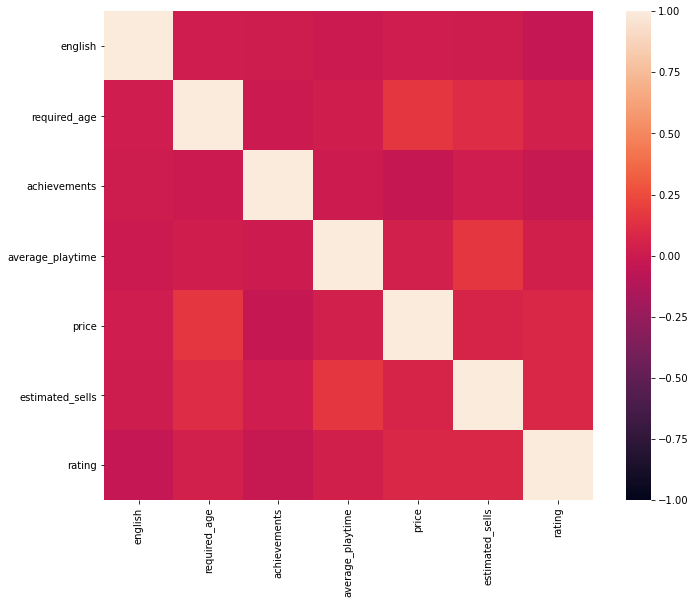

In [32]:
corrmat = df_train_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, vmin=-1, square=True)

In [33]:
corrmat[['estimated_sells']].sort_values( by=['estimated_sells'], ascending=False).iloc[1:,:]

estimated_sells
average_playtime         0.161612
required_age             0.110789
rating                   0.090395
price                    0.062935
achievements             0.022180
english                  0.014292

In [34]:
corrmat[['rating']].sort_values( by=['rating'], ascending=False).iloc[1:,:]

rating
price             0.090508
estimated_sells   0.090395
required_age      0.041111
average_playtime  0.031250
achievements     -0.020295
english          -0.037753

**Proyectar los datos con PCA, T-SNE o UMAP**

In [35]:
X_train = df_train.drop(columns=['estimated_sells','rating'])
y_train_regr = df_train['estimated_sells'].values
y_train_class = df_train['rating'].values
X_train.head(3)

name release_date  english                     developer  \
0      An Aspie Life   2018-03-29        1  Bradley Hennessey;Joe Watson   
1  GhostControl Inc.   2014-06-06        1                     bumblebee   
2            Deponia   2012-08-06        1        Daedalic Entertainment   

                        publisher          platforms  required_age  \
0               EnderLost Studios            windows             0   
1  Application Systems Heidelberg  windows;mac;linux             0   
2          Daedalic Entertainment  windows;mac;linux             0   

                                          categories  \
0                   Single-player;Steam Achievements   
1  Single-player;Steam Achievements;Steam Trading...   
2  Single-player;Steam Achievements;Steam Trading...   

                                           genres  \
0  Adventure;Casual;Free to Play;Indie;Simulation   
1                Casual;Indie;Simulation;Strategy   
2                                 Adventure;Indie   

                             tags  achievements  average_playtime  price  \
0    Free to Play;Adventure;Indie            23                 0   0.00   
1     Turn-Based;Indie;Simulation            53                65  10.99   
2  Adventure;Point & Click;Comedy            19               217   6.99   

                                   short_description  
0  One day your roommate Leaves for no reason. Yo...  
1  Manage a team of ghosthunters and free London ...  
2  In Deponia, the world has degenerated into a v...

In [36]:
preprocessing = ColumnTransformer([
    ('Scale', MinMaxScaler(), ['english','required_age','achievements','average_playtime','price']), 
    ('Vectorizer_platforms', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'platforms'),
    ('Vectorizer_genres', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'genres'), 
    ('Vectorizer_categories', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'categories'), 
    ('Vectorizer_developer', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'developer'), 
    ('Vectorizer_tags', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'tags'), 
    ('Vectorizer_publisher', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'publisher')])

In [37]:
pipeline_TSNE = Pipeline([('preprocessing', preprocessing),('TSNE', TSNE(random_state=42))])

In [38]:
pipeline_TSNE.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E548F83D0>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

In [39]:
X_TSNE = pipeline_TSNE.fit_transform(X_train)

In [40]:
X_TSNE

array([[-34.03737 , -63.12609 ],
       [ 30.279802,  36.92473 ],
       [ 58.84261 ,  44.0404  ],
       ...,
       [ 21.454031,  23.138094],
       [-46.506012, -22.933699],
       [-13.219445,  13.151011]], dtype=float32)

In [41]:
fig = px.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], color=y_train_class)
fig.show()

In [42]:
fig = px.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], color=np.log(y_train_regr))
fig.show()

Al efectuar el análisis exploratorio de datos (EDA) se pudo notar los siguientes puntos.

* No existen datos núlos ni filas repetidas en los datos

* El atributo **name** no tiene valores repetidos, es decir, los nombre de videojuegos son únicos en los datos disponibles. Por su parte **short_description Profile** solo tiene 52 valores repetidos.

* Los atributos **estimated_sells**, **achievements**, **average_playtime** y **price** tienen outliers que imposibilitan analizar correctamente sus distribuciones. Es necesario poder filtrar estos valores al entrenar un modelo. 

* Existen columnas categóricas con un gran desbalanceo, estas son **required_age** y  **english**. Por su parte, **required_age** en su mayoría tiene el valor 0, es decir sin restricción. La columna **english** tiene en gran mayoria el valor 1, es decir, que el juego está en idioma inglés. 

* La columna **release_date** contiene las féchas de lanzamiento, estas van desde el 2008 hasta el 2018, concentrandoce mayormente entre 2014 y 2018.

* Existen atributos categóricos que cuentan con un número muy grande de categorías, esto son **developer**, **publisher**, **categories**, **genres** y **tags**. Producto de estos atributos la cantidad de opciones totales es mayor a la cantidad de datos. Esto puede ser un problema al entrenar el modelo.

* Por último, **platforms**  y **rating** son columnas categóricas con pocas opciones y datos relativamente balanceados.

Luego de la correlación se obtienen los atributos que más afectan en los valores objetivos de este proyecto, **rating** y **estimated_sells**. 

* **estimated_sells** tiene una mayor correlación con los atributos **average_playtime** y **required_age**. Por su parte, **rating** tiene una mayor correlación con **price**. 

* Es importante recalcar que ninguna de estas correlaciones tiene una magnitud importante por lo que este problema requiere de obtnener relaciones ocultas entre los distintos atributos con el fín de predecir el éxito de un juego en cuestión.


Finalmente, al proyectar los datos en 2D se tiene dificultades en agrupat las clases de **rating** y en detectar tendensias en **estimated_sells**. Esto se puede explicar por la baja correlación de **rating** con los atributos y los outliers de **estimated_sells**.


---

## 3. Preparación de Datos

Para preparar nuestros datos, primero eliminamos duplicados y outliers.

### 3.1 Descartar datos nulos y outliers.

In [43]:
df_train.describe()

english  required_age  achievements  average_playtime        price  \
count  7881.000000    7881.00000   7881.000000       7881.000000  7881.000000   
mean      0.985789       0.78924     43.170156        439.296790     8.431342   
std       0.118369       3.55538    265.399206       3303.162083     8.755668   
min       0.000000       0.00000      0.000000          0.000000     0.000000   
25%       1.000000       0.00000      0.000000          0.000000     1.990000   
50%       1.000000       0.00000     15.000000         27.000000     6.990000   
75%       1.000000       0.00000     35.000000        251.000000    11.390000   
max       1.000000      18.00000   9821.000000     190625.000000    78.990000   

       estimated_sells  
count     7.881000e+03  
mean      2.105767e+05  
std       1.513926e+06  
min       3.600000e+03  
25%       9.724000e+03  
50%       2.150800e+04  
75%       7.357300e+04  
max       7.944129e+07

In [44]:
df_train = df_train.loc[(np.abs(stats.zscore(df_train['achievements'])) < 3)].reset_index(drop=True)
df_train = df_train.loc[(np.abs(stats.zscore(df_train['average_playtime'])) < 3)].reset_index(drop=True)
df_train = df_train.loc[(np.abs(stats.zscore(df_train['price'])) < 3)].reset_index(drop=True)
df_train = df_train.loc[(np.abs(stats.zscore(df_train['estimated_sells'])) < 3)].reset_index(drop=True)

In [45]:
df_train.describe()

english  required_age  achievements  average_playtime        price  \
count  7540.000000   7540.000000   7540.000000       7540.000000  7540.000000   
mean      0.985279      0.689257     24.519231        238.103979     7.623874   
std       0.120444      3.323775     44.053899        658.311692     6.942931   
min       0.000000      0.000000      0.000000          0.000000     0.000000   
25%       1.000000      0.000000      0.000000          0.000000     1.990000   
50%       1.000000      0.000000     15.000000         21.000000     6.990000   
75%       1.000000      0.000000     32.250000        238.000000    10.990000   
max       1.000000     18.000000    720.000000      10247.000000    33.990000   

       estimated_sells  
count     7.540000e+03  
mean      1.095115e+05  
std       2.910057e+05  
min       3.600000e+03  
25%       9.568000e+03  
50%       2.054000e+04  
75%       6.746450e+04  
max       3.057458e+06

### 3.2 Preprocesar datos categóricos y ordinales.

In [46]:
X_train = df_train.drop(columns=['estimated_sells','rating'])
y_train_regr = df_train['estimated_sells'].values
y_train_class = df_train['rating'].values

### 3.3 Escalar/estandarizar datos numéricos.

In [47]:
modelo_minmax = MinMax()
modelo_minmax.fit(X_train[['english','required_age','achievements','average_playtime','price']])

MinMax()

In [48]:
X_train_escalados = modelo_minmax.transform(X_train[['english','required_age','achievements','average_playtime','price']])
X_train_escalados.head()

english  required_age  achievements  average_playtime     price
0      1.0           0.0      0.031944          0.000000  0.000000
1      1.0           0.0      0.073611          0.006343  0.323330
2      1.0           0.0      0.026389          0.021177  0.205649
3      1.0           0.0      0.168056          0.121011  0.000000
4      1.0           0.0      0.009722          0.023909  0.235069

### 3.4 Codificar texto.

In [49]:
X_train['platforms'].str.split(';').str.join('|').str.get_dummies().head()

linux  mac  windows
0      0    0        1
1      1    1        1
2      1    1        1
3      0    0        1
4      0    1        1

In [50]:
X_train['categories'].str.split(';').str.join('|').str.get_dummies().head()

Captions available  Co-op  Commentary available  \
0                   0      0                     0   
1                   0      0                     0   
2                   0      0                     0   
3                   0      0                     0   
4                   0      0                     0   

   Cross-Platform Multiplayer  Full controller support  In-App Purchases  \
0                           0                        0                 0   
1                           0                        0                 0   
2                           0                        0                 0   
3                           0                        0                 1   
4                           0                        0                 0   

   Includes Source SDK  Includes level editor  Local Co-op  \
0                    0                      0            0   
1                    0                      0            0   
2                    0                      0            0   
3                    0                      0            0   
4                    0                      0            0   

   Local Multi-Player  ...  Stats  Steam Achievements  Steam Cloud  \
0                   0  ...      0                   1            0   
1                   0  ...      1                   1            1   
2                   0  ...      0                   1            1   
3                   0  ...      0                   1            0   
4                   0  ...      0                   1            1   

   Steam Leaderboards  Steam Trading Cards  Steam Turn Notifications  \
0                   0                    0                         0   
1                   0                    1                         0   
2                   0                    1                         0   
3                   0                    1                         0   
4                   0                    1                         0   

   Steam Workshop  SteamVR Collectibles  VR Support  Valve Anti-Cheat enabled  
0               0                     0           0                         0  
1               0                     0           0                         0  
2               0                     0           0                         0  
3               0                     0           0                         0  
4               0                     0           0                         0  

[5 rows x 29 columns]

In [51]:
X_train['genres'].str.split(';').str.join('|').str.get_dummies().head()

Action  Adventure  Animation & Modeling  Audio Production  Casual  \
0       0          1                     0                 0       1   
1       0          0                     0                 0       1   
2       0          1                     0                 0       0   
3       0          0                     0                 0       0   
4       0          1                     0                 0       1   

   Design & Illustration  Early Access  Education  Free to Play  \
0                      0             0          0             1   
1                      0             0          0             0   
2                      0             0          0             0   
3                      0             0          0             1   
4                      0             0          0             0   

   Game Development  ...  Racing  Sexual Content  Simulation  \
0                 0  ...       0               0           1   
1                 0  ...       0               0           1   
2                 0  ...       0               0           0   
3                 0  ...       0               0           0   
4                 0  ...       0               0           0   

   Software Training  Sports  Strategy  Utilities  Video Production  Violent  \
0                  0       0         0          0                 0        0   
1                  0       0         1          0                 0        0   
2                  0       0         0          0                 0        0   
3                  0       0         1          0                 0        0   
4                  0       0         0          0                 0        0   

   Web Publishing  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 26 columns]

In [52]:
X_train['developer'].str.split(';').str.join('|').str.get_dummies().head()

"Ellie"  #workshop  .dat  07th Expansion  100 Stones Interactive  \
0        0          0     0               0                       0   
1        0          0     0               0                       0   
2        0          0     0               0                       0   
3        0          0     0               0                       0   
4        0          0     0               0                       0   

   10Ants Hill  10th Art Studio  10tons Ltd  11 bit studios  \
0            0                0           0               0   
1            0                0           0               0   
2            0                0           0               0   
3            0                0           0               0   
4            0                0           0               0   

   14 Hours Productions  ...  觀象草圖 Astrolabe Draft  貓蛋  边境游戏工作室  银月网络  铸城工作室  \
0                     0  ...                     0   0        0     0      0   
1                     0  ...                     0   0        0     0      0   
2                     0  ...                     0   0        0     0      0   
3                     0  ...                     0   0        0     0      0   
4                     0  ...                     0   0        0     0      0   

   阿正不经  離水三尺工作室  雷武游戏  高考恋爱委员会  黄昏フロンティア  
0     0        0     0        0         0  
1     0        0     0        0         0  
2     0        0     0        0         0  
3     0        0     0        0         0  
4     0        0     0        0         0  

[5 rows x 5502 columns]

In [53]:
X_train['tags'].str.split(';').str.join('|').str.get_dummies().head()

1980s  1990's  2D  2D Fighter  3D  3D Platformer  4 Player Local  4X  6DOF  \
0      0       0   0           0   0              0               0   0     0   
1      0       0   0           0   0              0               0   0     0   
2      0       0   0           0   0              0               0   0     0   
3      0       0   0           0   0              0               0   0     0   
4      0       0   0           0   0              0               0   0     0   

   Abstract  ...  Wargame  Warhammer 40K  Web Publishing  Werewolves  Western  \
0         0  ...        0              0               0           0        0   
1         0  ...        0              0               0           0        0   
2         0  ...        0              0               0           0        0   
3         0  ...        0              0               0           0        0   
4         0  ...        0              0               0           0        0   

   Word Game  World War I  World War II  Wrestling  Zombies  
0          0            0             0          0        0  
1          0            0             0          0        0  
2          0            0             0          0        0  
3          0            0             0          0        0  
4          0            0             0          0        0  

[5 rows x 301 columns]

In [54]:
X_train['publisher'].str.split(';').str.join('|').str.get_dummies().head()

AFBIK Studio   Dagestan Technology   Fazan   GrabTheGames  \
0  0              0                     0       0              0   
1  0              0                     0       0              0   
2  0              0                     0       0              0   
3  0              0                     0       0              0   
4  0              0                     0       0              0   

    GungHo Online Entertainment America, Inc.\t   MyACG Studio  \
0                                             0              0   
1                                             0              0   
2                                             0              0   
3                                             0              0   
4                                             0              0   

    SOFTSTAR TECHNOLOGY BEIJINGCOLTD   Sean Davy   Volha  ...  菠菜游戏  \
0                                  0           0       0  ...     0   
1                                  0           0       0  ...     0   
2                                  0           0       0  ...     0   
3                                  0           0       0  ...     0   
4                                  0           0       0  ...     0   

   蘇州大禹網絡科技有限公司  觀象草圖 Astrolabe Draft  轻文  边境游戏工作室  迷糊的安安  银月网络  離水三尺工作室  \
0             0                     0   0        0      0     0        0   
1             0                     0   0        0      0     0        0   
2             0                     0   0        0      0     0        0   
3             0                     0   0        0      0     0        0   
4             0                     0   0        0      0     0        0   

   雷武游戏  香港商河洛互動娛樂股份有限公司  
0     0                0  
1     0                0  
2     0                0  
3     0                0  
4     0                0  

[5 rows x 3898 columns]

### 3.5 Setear las transformaciones en un ColumnTransformer

In [55]:
preprocessing = ColumnTransformer([
    ('Scale', MinMaxScaler(), ['english','required_age','achievements','average_playtime','price']), 
    ('Vectorizer_platforms', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'platforms'),
    ('Vectorizer_genres', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'genres'), 
    ('Vectorizer_categories', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'categories'), 
    ('Vectorizer_developer', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'developer'), 
    ('Vectorizer_tags', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'tags'), 
    ('Vectorizer_publisher', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2), decode_error='ignore'),'publisher')])

**Prueba de preprocesamiento**

In [56]:
pipeline_clasificador = Pipeline([('preprocessing', preprocessing)])
pipeline_clasificador.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53F9A490>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

**Prueba de preprocesamiento y disminución de dimencionalidad**

In [57]:
pipeline_TSNE = Pipeline([('preprocessing', preprocessing),('TSNE', TSNE(random_state=42))])
pipeline_TSNE.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53F9A490>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

### 3.6 Probar las transformaciones.

**Prueba de preprocesamiento**

In [58]:
X_train_prepro = pipeline_clasificador.fit_transform(X_train)

In [59]:
X_train_prepro.shape

(7540, 21528)

**Prueba de preprocesamiento y disminución de dimencionalidad**

In [60]:
X_TSNE = pipeline_TSNE.fit_transform(X_train)

In [61]:
fig = px.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], color=y_train_class)
fig.show()

In [62]:
fig = px.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], color=np.log(y_train_regr))
fig.show()

---

## 4. Baseline

Adjuntamos las transformaciones anteriores en un solo `Pipeline` y agregamos al final un clasificador sencillo `ClasificadorX` 


In [63]:
X_test = pd.read_pickle('test.pickle')

In [64]:
X_test.head(3)

name release_date  english       developer  \
0          Frog Climbers   2016-10-06        1        TeamCrew   
1                 Aztaka   2009-11-05        1  Citeremis Inc.   
2  Assault Spy / アサルトスパイ   2018-10-02        1           Wazen   

           publisher    platforms  required_age  \
0     Dear Villagers      windows             0   
1     Citeremis Inc.  windows;mac             0   
2  NIS America, Inc.      windows             0   

                                          categories            genres  \
0  Single-player;Local Multi-Player;Shared/Split ...             Indie   
1                                      Single-player  Action;RPG;Indie   
2              Single-player;Full controller support      Action;Indie   

                                 tags  achievements  average_playtime  price  \
0       Indie;Local Multiplayer;Funny             0               239   4.99   
1                    RPG;Action;Indie             0                 0   3.99   
2  Action;Indie;Character Action Game            28                 0  24.99   

                                   short_description  
0  Climb mountains. Beat your friends. Be a douch...  
1  Inspired by Aztec legend, this action/rpg side...  
2  Dash, evade, and smash your way to the truth a...

**Clasificación**

In [65]:
pipeline_clf = Pipeline([('preprocessing', preprocessing),('SelectPercentiles', SelectPercentile(f_classif, percentile=90)),('clf', MultinomialNB())])
pipeline_clf.fit(X_train,y_train_class)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53F9A490>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

In [66]:
y_pred_clf = pipeline_clf.predict(X_test)
y_pred_clf

array(['Mostly Positive', 'Positive', 'Positive', 'Mixed', 'Positive',
       'Positive', 'Positive', 'Negative', 'Mixed', 'Positive',
       'Negative', 'Very Positive', 'Positive', 'Mixed', 'Positive',
       'Negative', 'Positive', 'Negative', 'Mostly Positive', 'Positive',
       'Very Positive', 'Positive', 'Positive', 'Mixed', 'Positive',
       'Mixed', 'Positive', 'Very Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Mixed', 'Positive', 'Positive',
       'Positive', 'Mostly Positive', 'Positive', 'Mixed',
       'Mostly Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Negative', 'Positive', 'Negative', 'Mixed', 'Mixed', 'Positive',
       'Mostly Positive', 'Mixed', 'Negative', 'Mostly Positive',
       'Positive', 'Very Positive', 'Positive', 'Mixed', 'Very Positive',
       'Positive', 'Negative', 'Mixed', 'Positive', 'Mostly Positive',
       'Positive', 'Positive', 'Mixed', 'Negative', 'Mixed', 'Positive',
       'Positive', 'Mostly Positive', 

**Regresor**

In [67]:
pipeline_rg = Pipeline([('preprocessing', preprocessing),('SelectPercentiles', SelectPercentile(f_classif, percentile=10)),('rg',SVR())])

In [68]:
pipeline_rg.fit(X_train,y_train_regr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53F9A490>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

In [69]:
y_pred_rg = pipeline_rg.predict(X_test)
y_pred_rg

array([20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       21327.45218429, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 21328.44813248, 20423.12034502, 20423.12034502,
       21335.0868683 , 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 21333.11149426,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 21274.42701729, 20423.12034502,
       20423.12034502, 20423.12034502, 21326.44816505, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       20423.12034502, 20423.12034502, 20423.12034502, 20423.12034502,
       21273.50236143, 20423.12034502, 20423.12034502, 20423.12034502,
      

---

## 5. Optimización del Modelo

Ahora, agregamos selección y/o reducción de atributos y probaremos una combinación de diferentes parámetros para mejorar nuestro modelo:


*Nota*: Procuren hacer Gridsearch sobre espacios de búsqueda razonables. Es decir, no estén 3 días buscando la mejor configuración...

**Clasificador**

In [70]:
pipeline_clf = Pipeline([('preprocessing', preprocessing),('Selection', SelectPercentile(f_classif, percentile=90)),('clf', MultinomialNB())])

In [73]:
params = [
       # selección
        {'Selection__percentile': [20, 40, 60, 80]},
       # LogisticRegression
       {'clf': [LogisticRegression()],
        'clf__penalty': ['l2','none'],
        'clf__C': [0.1, 1, 10, 100]},
       # RandomForestClassifier    
       {'clf': [RandomForestClassifier()],
        'clf__n_estimators': [50,100,200],
        'clf__criterion': ['gini', 'entropy']},
       {'clf': [SVC()],
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree': [3,4,5],
        'clf__C': [0.1, 1, 10, 100]},
       {'clf': [MultinomialNB()],
        'clf__alpha': [0,0.5,1],
        'clf__fit_prior': [True, False],}
       ]


MultinomialNB

hgs_clf = HalvingGridSearchCV(pipeline_clf, params,verbose=10)

In [74]:
hgs_clf.fit(X_train,y_train_class)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 279
max_resources_: 7540
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 279
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5; 1/72] START Selection__percentile=20...................................
[CV 1/5; 1/72] END Selection__percentile=20;, score=(train=0.596, test=0.236) total time=   0.2s
[CV 2/5; 1/72] START Selection__percentile=20...................................
[CV 2/5; 1/72] END Selection__percentile=20;, score=(train=0.520, test=0.291) total time=   0.2s
[CV 3/5; 1/72] START Selection__percentile=20...................................
[CV 3/5; 1/72] END Selection__percentile=20;, score=(train=0.547, test=0.345) total time=   0.2s
[CV 4/5; 1/72] START Selection__percentile=20...................................
[CV 4/5; 1/72] END Selection__percentile=20;, score=(train=0.538, test=0.345) total time=   0.2s
[CV 5/5; 1/72] START Selec

[CV 2/5; 9/72] END clf=LogisticRegression(), clf__C=10, clf__penalty=l2;, score=(train=1.000, test=0.327) total time=   0.3s
[CV 3/5; 9/72] START clf=LogisticRegression(), clf__C=10, clf__penalty=l2.......
[CV 3/5; 9/72] END clf=LogisticRegression(), clf__C=10, clf__penalty=l2;, score=(train=1.000, test=0.200) total time=   0.4s
[CV 4/5; 9/72] START clf=LogisticRegression(), clf__C=10, clf__penalty=l2.......
[CV 4/5; 9/72] END clf=LogisticRegression(), clf__C=10, clf__penalty=l2;, score=(train=1.000, test=0.345) total time=   0.3s
[CV 5/5; 9/72] START clf=LogisticRegression(), clf__C=10, clf__penalty=l2.......
[CV 5/5; 9/72] END clf=LogisticRegression(), clf__C=10, clf__penalty=l2;, score=(train=1.000, test=0.127) total time=   0.3s
[CV 1/5; 10/72] START clf=LogisticRegression(), clf__C=10, clf__penalty=none....
[CV 1/5; 10/72] END clf=LogisticRegression(), clf__C=10, clf__penalty=none;, score=(train=1.000, test=0.291) total time=   0.3s
[CV 2/5; 10/72] START clf=LogisticRegression(), 

[CV 4/5; 16/72] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=50;, score=(train=1.000, test=0.291) total time=   0.3s
[CV 5/5; 16/72] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=50
[CV 5/5; 16/72] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=50;, score=(train=1.000, test=0.218) total time=   0.3s
[CV 1/5; 17/72] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=100
[CV 1/5; 17/72] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=100;, score=(train=1.000, test=0.309) total time=   0.4s
[CV 2/5; 17/72] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=100
[CV 2/5; 17/72] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=100;, score=(train=1.000, test=0.327) total time=   0.4s
[CV 3/5; 17/72] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=100
[CV 3/5; 17/72]

[CV 1/5; 24/72] END clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly;, score=(train=0.341, test=0.236) total time=   0.2s
[CV 2/5; 24/72] START clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly....
[CV 2/5; 24/72] END clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly;, score=(train=0.381, test=0.327) total time=   0.2s
[CV 3/5; 24/72] START clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly....
[CV 3/5; 24/72] END clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly;, score=(train=0.332, test=0.200) total time=   0.2s
[CV 4/5; 24/72] START clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly....
[CV 4/5; 24/72] END clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly;, score=(train=0.372, test=0.364) total time=   0.3s
[CV 5/5; 24/72] START clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly....
[CV 5/5; 24/72] END clf=SVC(), clf__C=0.1, clf__degree=4, clf__kernel=poly;, score=(train=0.345, test=0.255) total time=   0.2s
[CV 1/5; 25/72] START clf=SVC(), clf

[CV 1/5; 32/72] END clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly;, score=(train=0.713, test=0.291) total time=   0.2s
[CV 2/5; 32/72] START clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly......
[CV 2/5; 32/72] END clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly;, score=(train=0.619, test=0.273) total time=   0.2s
[CV 3/5; 32/72] START clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly......
[CV 3/5; 32/72] END clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly;, score=(train=0.726, test=0.291) total time=   0.2s
[CV 4/5; 32/72] START clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly......
[CV 4/5; 32/72] END clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly;, score=(train=0.637, test=0.236) total time=   0.2s
[CV 5/5; 32/72] START clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly......
[CV 5/5; 32/72] END clf=SVC(), clf__C=1, clf__degree=3, clf__kernel=poly;, score=(train=0.574, test=0.236) total time=   0.2s
[CV 1/5; 33/72] START clf=SVC(), clf__C=1, clf

[CV 1/5; 40/72] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly;, score=(train=0.650, test=0.236) total time=   0.2s
[CV 2/5; 40/72] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly......
[CV 2/5; 40/72] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly;, score=(train=0.619, test=0.255) total time=   0.2s
[CV 3/5; 40/72] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly......
[CV 3/5; 40/72] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly;, score=(train=0.659, test=0.182) total time=   0.2s
[CV 4/5; 40/72] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly......
[CV 4/5; 40/72] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly;, score=(train=0.709, test=0.309) total time=   0.2s
[CV 5/5; 40/72] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly......
[CV 5/5; 40/72] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=poly;, score=(train=0.601, test=0.255) total time=   0.2s
[CV 1/5; 41/72] START clf=SVC(), clf__C=1, clf

[CV 1/5; 48/72] END clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly;, score=(train=0.960, test=0.345) total time=   0.2s
[CV 2/5; 48/72] START clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly.....
[CV 2/5; 48/72] END clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly;, score=(train=0.883, test=0.309) total time=   0.3s
[CV 3/5; 48/72] START clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly.....
[CV 3/5; 48/72] END clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly;, score=(train=0.969, test=0.309) total time=   0.2s
[CV 4/5; 48/72] START clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly.....
[CV 4/5; 48/72] END clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly;, score=(train=0.843, test=0.218) total time=   0.2s
[CV 5/5; 48/72] START clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly.....
[CV 5/5; 48/72] END clf=SVC(), clf__C=10, clf__degree=4, clf__kernel=poly;, score=(train=0.879, test=0.236) total time=   0.2s
[CV 1/5; 49/72] START clf=SVC(), clf__C=1

[CV 1/5; 56/72] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=1.000, test=0.345) total time=   0.2s
[CV 2/5; 56/72] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 2/5; 56/72] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=1.000, test=0.364) total time=   0.3s
[CV 3/5; 56/72] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 3/5; 56/72] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=1.000, test=0.309) total time=   0.2s
[CV 4/5; 56/72] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 4/5; 56/72] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=1.000, test=0.327) total time=   0.2s
[CV 5/5; 56/72] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 5/5; 56/72] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=1.000, test=0.236) total time=   0.2s
[CV 1/5; 57/72] START clf=SVC(), clf

[CV 1/5; 64/72] END clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly;, score=(train=0.996, test=0.345) total time=   0.2s
[CV 2/5; 64/72] START clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly....
[CV 2/5; 64/72] END clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly;, score=(train=0.964, test=0.273) total time=   0.2s
[CV 3/5; 64/72] START clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly....
[CV 3/5; 64/72] END clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly;, score=(train=0.996, test=0.291) total time=   0.2s
[CV 4/5; 64/72] START clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly....
[CV 4/5; 64/72] END clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly;, score=(train=0.960, test=0.218) total time=   0.2s
[CV 5/5; 64/72] START clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly....
[CV 5/5; 64/72] END clf=SVC(), clf__C=100, clf__degree=5, clf__kernel=poly;, score=(train=0.973, test=0.273) total time=   0.2s
[CV 1/5; 65/72] START clf=SVC(), clf

[CV 1/5; 72/72] END clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False;, score=(train=0.780, test=0.255) total time=   0.2s
[CV 2/5; 72/72] START clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False...
[CV 2/5; 72/72] END clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False;, score=(train=0.776, test=0.327) total time=   0.2s
[CV 3/5; 72/72] START clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False...
[CV 3/5; 72/72] END clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False;, score=(train=0.776, test=0.291) total time=   0.2s
[CV 4/5; 72/72] START clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False...
[CV 4/5; 72/72] END clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False;, score=(train=0.807, test=0.345) total time=   0.2s
[CV 5/5; 72/72] START clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False...
[CV 5/5; 72/72] END clf=MultinomialNB(), clf__alpha=1, clf__fit_prior=False;, score=(train=0.789, test=0.218) total time=   0.2s
----------
iter: 1
n_candidates

[CV 5/5; 7/24] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=rbf;, score=(train=1.000, test=0.311) total time=   1.0s
[CV 1/5; 8/24] START clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf.......
[CV 1/5; 8/24] END clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf;, score=(train=0.997, test=0.263) total time=   1.1s
[CV 2/5; 8/24] START clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf.......
[CV 2/5; 8/24] END clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf;, score=(train=1.000, test=0.269) total time=   1.0s
[CV 3/5; 8/24] START clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf.......
[CV 3/5; 8/24] END clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf;, score=(train=0.996, test=0.287) total time=   1.0s
[CV 4/5; 8/24] START clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf.......
[CV 4/5; 8/24] END clf=SVC(), clf__C=10, clf__degree=3, clf__kernel=rbf;, score=(train=0.996, test=0.281) total time=   1.0s
[CV 5/5; 8/24] START clf=SVC(), clf__C=10, clf__de

[CV 3/5; 15/24] END Selection__percentile=40;, score=(train=0.553, test=0.287) total time=   0.8s
[CV 4/5; 15/24] START Selection__percentile=40..................................
[CV 4/5; 15/24] END Selection__percentile=40;, score=(train=0.531, test=0.263) total time=   0.8s
[CV 5/5; 15/24] START Selection__percentile=40..................................
[CV 5/5; 15/24] END Selection__percentile=40;, score=(train=0.561, test=0.275) total time=   0.8s
[CV 1/5; 16/24] START clf=MultinomialNB(), clf__alpha=0.5, clf__fit_prior=False.
[CV 1/5; 16/24] END clf=MultinomialNB(), clf__alpha=0.5, clf__fit_prior=False;, score=(train=0.789, test=0.275) total time=   0.8s
[CV 2/5; 16/24] START clf=MultinomialNB(), clf__alpha=0.5, clf__fit_prior=False.
[CV 2/5; 16/24] END clf=MultinomialNB(), clf__alpha=0.5, clf__fit_prior=False;, score=(train=0.779, test=0.281) total time=   0.8s
[CV 3/5; 16/24] START clf=MultinomialNB(), clf__alpha=0.5, clf__fit_prior=False.
[CV 3/5; 16/24] END clf=MultinomialNB()

[CV 3/5; 23/24] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=rbf;, score=(train=0.574, test=0.311) total time=   0.9s
[CV 4/5; 23/24] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=rbf.......
[CV 4/5; 23/24] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=rbf;, score=(train=0.505, test=0.275) total time=   1.0s
[CV 5/5; 23/24] START clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=rbf.......
[CV 5/5; 23/24] END clf=SVC(), clf__C=1, clf__degree=5, clf__kernel=rbf;, score=(train=0.547, test=0.257) total time=   1.0s
[CV 1/5; 24/24] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 1/5; 24/24] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=0.999, test=0.281) total time=   1.0s
[CV 2/5; 24/24] START clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly....
[CV 2/5; 24/24] END clf=SVC(), clf__C=100, clf__degree=3, clf__kernel=poly;, score=(train=0.999, test=0.246) total time=   1.0s
[CV 3/5; 24/24] START clf=SVC(), clf__C=100, 

[CV 3/5; 7/8] END clf=LogisticRegression(), clf__C=0.1, clf__penalty=l2;, score=(train=0.723, test=0.297) total time=   3.3s
[CV 4/5; 7/8] START clf=LogisticRegression(), clf__C=0.1, clf__penalty=l2.......
[CV 4/5; 7/8] END clf=LogisticRegression(), clf__C=0.1, clf__penalty=l2;, score=(train=0.722, test=0.307) total time=   3.3s
[CV 5/5; 7/8] START clf=LogisticRegression(), clf__C=0.1, clf__penalty=l2.......
[CV 5/5; 7/8] END clf=LogisticRegression(), clf__C=0.1, clf__penalty=l2;, score=(train=0.714, test=0.325) total time=   3.4s
[CV 1/5; 8/8] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=200
[CV 1/5; 8/8] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=200;, score=(train=0.999, test=0.313) total time=   5.9s
[CV 2/5; 8/8] START clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=200
[CV 2/5; 8/8] END clf=RandomForestClassifier(), clf__criterion=entropy, clf__n_estimators=200;, score=(train=1.000, test=0.3

HalvingGridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('Scale',
                                                                                MinMaxScaler(),
                                                                                ['english',
                                                                                 'required_age',
                                                                                 'achievements',
                                                                                 'average_playtime',
                                                                                 'price']),
                                                                               ('Vectorizer_platforms',
                                                                                CountVectorizer(decode_error='ignore',
                                                 

In [75]:
hgs_clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53F931F0>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

Pudimos ver que mejor modelo mejora/no mejora los resultados obtenidos en el baseline.

In [76]:
pipeline_rg = Pipeline([('preprocessing', preprocessing),('Selection', SelectPercentile(f_classif, percentile=10)),('rg',SVR())])

In [78]:
params = [
       # selección
        {'Selection__percentile': [20, 40, 60, 80]},
       # SGDRegressor    
       {'rg': [SGDRegressor()],
        'rg__max_iter': [100,1000,10000],
        'rg__penalty': ['l2', 'l1', 'elasticnet'],
        'rg__tol': [1e-4, 1e-3,1e-2]},
       # SVR
       {'rg': [SVR()],
        'rg__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'rg__degree': [3,4,5],
        'rg__C': [0.1, 1, 10, 100]},
       # DecisionTreeRegressor
       {'rg': [DecisionTreeRegressor()],
        'rg__splitter': ['best', 'random'],
        'rg__min_samples_split': [2,3,4],}
       ]

hgs_rg = HalvingGridSearchCV(pipeline_rg, params,verbose=10)

In [79]:
hgs_rg.fit(X_train,y_train_regr)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 93
max_resources_: 7540
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 85
n_resources: 93
Fitting 5 folds for each of 85 candidates, totalling 425 fits
[CV 1/5; 1/85] START Selection__percentile=20...................................
[CV 1/5; 1/85] END Selection__percentile=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 1/85] START Selection__percentile=20...................................
[CV 2/5; 1/85] END Selection__percentile=20;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 1/85] START Selection__percentile=20...................................
[CV 3/5; 1/85] END Selection__percentile=20;, score=(train=-0.151, test=-0.030) total time=   0.0s
[CV 4/5; 1/85] START Selection__percentile=20...................................
[CV 4/5; 1/85] END Selection__percentile=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 1/85] START Selection__

[CV 1/5; 9/85] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 9/85] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 2/5; 9/85] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=0.634, test=-0.529) total time=   0.0s
[CV 3/5; 9/85] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 3/5; 9/85] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=0.545, test=-19.221) total time=   0.0s
[CV 4/5; 9/85] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 4/5; 9/85] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 9/85] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 5/5; 9/85] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(tr

[CV 2/5; 16/85] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01;, score=(train=0.869, test=-0.194) total time=   0.0s
[CV 3/5; 16/85] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01
[CV 3/5; 16/85] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01;, score=(train=0.568, test=-21.005) total time=   0.0s
[CV 4/5; 16/85] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01
[CV 4/5; 16/85] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 16/85] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01
[CV 5/5; 16/85] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l2, rg__tol=0.01;, score=(train=0.724, test=-5.534) total time=   0.0s
[CV 1/5; 17/85] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l1, rg__tol=0.0001
[CV 1/5; 17/85] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=l1, rg__tol=

[CV 2/5; 23/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001;, score=(train=0.860, test=-0.203) total time=   0.0s
[CV 3/5; 23/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001
[CV 3/5; 23/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001;, score=(train=0.556, test=-19.239) total time=   0.0s
[CV 4/5; 23/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001
[CV 4/5; 23/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 23/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001
[CV 5/5; 23/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.0001;, score=(train=0.674, test=-4.368) total time=   0.0s
[CV 1/5; 24/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l2, rg__tol=0.001
[CV 1/5; 24/85] END rg=SGDRegressor(), rg__max_iter=10000, rg

[CV 3/5; 30/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.001;, score=(train=0.545, test=-18.965) total time=   0.0s
[CV 4/5; 30/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.001
[CV 4/5; 30/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 30/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.001
[CV 5/5; 30/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.001;, score=(train=0.732, test=-5.775) total time=   0.0s
[CV 1/5; 31/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.01
[CV 1/5; 31/85] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 31/85] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.01
[CV 2/5; 31/

[CV 2/5; 38/85] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 38/85] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf.........
[CV 3/5; 38/85] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.151, test=-0.030) total time=   0.0s
[CV 4/5; 38/85] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf.........
[CV 4/5; 38/85] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 38/85] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf.........
[CV 5/5; 38/85] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.188, test=-0.225) total time=   0.0s
[CV 1/5; 39/85] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=sigmoid.....
[CV 1/5; 39/85] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 39/85] START rg=SVR(), rg__C=0.1, rg__degree=4, rg

[CV 2/5; 46/85] END rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 46/85] START rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf...........
[CV 3/5; 46/85] END rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf;, score=(train=-0.151, test=-0.030) total time=   0.0s
[CV 4/5; 46/85] START rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf...........
[CV 4/5; 46/85] END rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 46/85] START rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf...........
[CV 5/5; 46/85] END rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=rbf;, score=(train=-0.188, test=-0.225) total time=   0.0s
[CV 1/5; 47/85] START rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=sigmoid.......
[CV 1/5; 47/85] END rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 47/85] START rg=SVR(), rg__C=1, rg__degree=3, rg__kernel=sig

[CV 3/5; 54/85] END rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=rbf;, score=(train=-0.151, test=-0.030) total time=   0.0s
[CV 4/5; 54/85] START rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=rbf...........
[CV 4/5; 54/85] END rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 54/85] START rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=rbf...........
[CV 5/5; 54/85] END rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=rbf;, score=(train=-0.188, test=-0.225) total time=   0.0s
[CV 1/5; 55/85] START rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=sigmoid.......
[CV 1/5; 55/85] END rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 55/85] START rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=sigmoid.......
[CV 2/5; 55/85] END rg=SVR(), rg__C=1, rg__degree=5, rg__kernel=sigmoid;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 55/85] START rg=SVR(), rg__C=1, rg__degree=5, rg__kernel

[CV 5/5; 62/85] END rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=rbf;, score=(train=-0.188, test=-0.225) total time=   0.0s
[CV 1/5; 63/85] START rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid......
[CV 1/5; 63/85] END rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 63/85] START rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid......
[CV 2/5; 63/85] END rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 63/85] START rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid......
[CV 3/5; 63/85] END rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid;, score=(train=-0.151, test=-0.030) total time=   0.0s
[CV 4/5; 63/85] START rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid......
[CV 4/5; 63/85] END rg=SVR(), rg__C=10, rg__degree=4, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 63/85] START rg=SVR(), rg__C=10, rg__degree

[CV 5/5; 70/85] END rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=rbf;, score=(train=-0.188, test=-0.230) total time=   0.0s
[CV 1/5; 71/85] START rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid.....
[CV 1/5; 71/85] END rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 71/85] START rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid.....
[CV 2/5; 71/85] END rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 71/85] START rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid.....
[CV 3/5; 71/85] END rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid;, score=(train=-0.150, test=-0.029) total time=   0.0s
[CV 4/5; 71/85] START rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid.....
[CV 4/5; 71/85] END rg=SVR(), rg__C=100, rg__degree=3, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 71/85] START rg=SVR(), rg__C=100, rg__

[CV 5/5; 78/85] END rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=rbf;, score=(train=-0.188, test=-0.230) total time=   0.0s
[CV 1/5; 79/85] START rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid.....
[CV 1/5; 79/85] END rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 79/85] START rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid.....
[CV 2/5; 79/85] END rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid;, score=(train=-0.059, test=-0.274) total time=   0.0s
[CV 3/5; 79/85] START rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid.....
[CV 3/5; 79/85] END rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid;, score=(train=-0.150, test=-0.029) total time=   0.0s
[CV 4/5; 79/85] START rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid.....
[CV 4/5; 79/85] END rg=SVR(), rg__C=100, rg__degree=5, rg__kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 79/85] START rg=SVR(), rg__C=100, rg__

[CV 1/5; 1/29] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=0.228, test=-0.014) total time=   0.3s
[CV 2/5; 1/29] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 2/5; 1/29] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=nan, test=nan) total time=   0.2s
[CV 3/5; 1/29] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 3/5; 1/29] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=0.195, test=0.223) total time=   0.3s
[CV 4/5; 1/29] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 4/5; 1/29] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=(train=0.127, test=-0.157) total time=   0.3s
[CV 5/5; 1/29] START rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001
[CV 5/5; 1/29] END rg=SGDRegressor(), rg__max_iter=100, rg__penalty=l1, rg__tol=0.001;, score=

[CV 3/5; 8/29] END rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best;, score=(train=0.449, test=0.395) total time=   0.3s
[CV 4/5; 8/29] START rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best
[CV 4/5; 8/29] END rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best;, score=(train=0.442, test=-1.393) total time=   0.3s
[CV 5/5; 8/29] START rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best
[CV 5/5; 8/29] END rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best;, score=(train=0.695, test=-0.509) total time=   0.3s
[CV 1/5; 9/29] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 1/5; 9/29] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.333, test=-0.047) total time=   0.3s
[CV 2/5; 9/29] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 2/5; 9/29] END rg=SGDRegressor(), rg__max

[CV 1/5; 16/29] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear;, score=(train=-0.141, test=-0.060) total time=   0.3s
[CV 2/5; 16/29] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear......
[CV 2/5; 16/29] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear;, score=(train=nan, test=nan) total time=   0.2s
[CV 3/5; 16/29] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear......
[CV 3/5; 16/29] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear;, score=(train=-0.124, test=-0.179) total time=   0.3s
[CV 4/5; 16/29] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear......
[CV 4/5; 16/29] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear;, score=(train=-0.094, test=-0.183) total time=   0.3s
[CV 5/5; 16/29] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear......
[CV 5/5; 16/29] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=linear;, score=(train=-0.074, test=-0.101) total time=   0.3s
[CV 1/5; 17/29] START rg=SVR(), rg__C=0.1,

[CV 4/5; 23/29] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.0001;, score=(train=0.169, test=-0.256) total time=   0.3s
[CV 5/5; 23/29] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.0001
[CV 5/5; 23/29] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=elasticnet, rg__tol=0.0001;, score=(train=0.240, test=0.307) total time=   0.3s
[CV 1/5; 24/29] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l1, rg__tol=0.01
[CV 1/5; 24/29] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l1, rg__tol=0.01;, score=(train=0.355, test=-0.059) total time=   0.4s
[CV 2/5; 24/29] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l1, rg__tol=0.01
[CV 2/5; 24/29] END rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l1, rg__tol=0.01;, score=(train=nan, test=nan) total time=   0.2s
[CV 3/5; 24/29] START rg=SGDRegressor(), rg__max_iter=10000, rg__penalty=l1, rg__tol=0.01
[CV 3/5; 24/29] END rg=SGDRegressor(), rg__max_i

[CV 4/5; 1/10] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.419, test=0.145) total time=   1.1s
[CV 5/5; 1/10] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 5/5; 1/10] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.322, test=0.043) total time=   1.1s
[CV 1/5; 2/10] START rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best
[CV 1/5; 2/10] END rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best;, score=(train=0.184, test=0.003) total time=   1.1s
[CV 2/5; 2/10] START rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best
[CV 2/5; 2/10] END rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best;, score=(train=0.216, test=-0.005) total time=   1.0s
[CV 3/5; 2/10] START rg=DecisionTreeRegressor(), rg__min_samples_split=4, rg__splitter=best
[CV 3/5; 2/10] END rg=DecisionTreeRegressor(), 

[CV 1/5; 9/10] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.094, test=-0.075) total time=   1.2s
[CV 2/5; 9/10] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf..........
[CV 2/5; 9/10] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.086, test=-0.110) total time=   1.2s
[CV 3/5; 9/10] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf..........
[CV 3/5; 9/10] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.117, test=-0.094) total time=   1.1s
[CV 4/5; 9/10] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf..........
[CV 4/5; 9/10] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.090, test=-0.060) total time=   1.1s
[CV 5/5; 9/10] START rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf..........
[CV 5/5; 9/10] END rg=SVR(), rg__C=0.1, rg__degree=4, rg__kernel=rbf;, score=(train=-0.086, test=-0.161) total time=   1.0s
[CV 1/5; 10/10] START rg=DecisionTreeRegressor(), rg__mi

[CV 1/5; 2/2] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.249, test=0.034) total time=  11.8s
[CV 2/5; 2/2] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 2/5; 2/2] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.234, test=0.081) total time=  11.8s
[CV 3/5; 2/2] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 3/5; 2/2] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=0.272, test=0.034) total time=  11.8s
[CV 4/5; 2/2] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 4/5; 2/2] END rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01;, score=(train=nan, test=nan) total time=   8.9s
[CV 5/5; 2/2] START rg=SGDRegressor(), rg__max_iter=1000, rg__penalty=elasticnet, rg__tol=0.01
[CV 5/5; 2/2] END rg=SGDRegressor(), rg_

HalvingGridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('Scale',
                                                                                MinMaxScaler(),
                                                                                ['english',
                                                                                 'required_age',
                                                                                 'achievements',
                                                                                 'average_playtime',
                                                                                 'price']),
                                                                               ('Vectorizer_platforms',
                                                                                CountVectorizer(decode_error='ignore',
                                                 

In [80]:
hgs_rg.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['english', 'required_age',
                                                   'achievements',
                                                   'average_playtime',
                                                   'price']),
                                                 ('Vectorizer_platforms',
                                                  CountVectorizer(decode_error='ignore',
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x0000024E53EF19D0>),
                                                  'platforms'),
                                                 ('Vectorizer_genres',
               

---

## 6. Conclusiones

Algunas respuestas que podrían plantearse pueden ser:

- ¿Pudieron resolver exitosamente el problema?
- ¿Son aceptables los resultados obtenidos?


- ¿Como fue el rendimiento del baseline?
- ¿Pudieron optimizar el baseline?
- ¿Que tanto mejoro el baseline con respecto a sus optimizaciones?


- ¿Estuvieron conformes con sus resultados?
- ¿Creen que hayan mejores formas de modelar el problema?
- ¿Creen que fue buena idea usar una competencia de por medio?
- ¿En general, qué aprendieron en el pryecto?¿Qué no aprendieron y les gustaría haber aprendido?
- Etc...

**OJO** si usted decide responder parte de estas preguntas, debe redactarlas en un formato de informe y no responderlas directamente.

---

<br>

### Anexo: Generación de Archivo Submit de la Competencia

Para subir los resultados obtenidos a la pagina de CodaLab utilice la función `generateFiles` entregada mas abajo. Esto es debido a que usted deberá generar archivos que respeten extrictamente el formato de CodaLab, de lo contario los resultados no se veran reflejados en la pagina de la competencia.

Para los resultados obtenidos en su modelo de clasificación y regresión, estos serán guardados en un archivo zip que contenga los archivos `predicctions_clf.txt` para la clasificación y `predicctions_rgr.clf` para la regresión. Los resultados, como se comento antes, deberan ser obtenidos en base al dataset `test.pickle` y en cada una de las lineas deberan presentar las predicciones realizadas.

Ejemplos de archivos:

- [ ] `predicctions_clf.txt`

        Mostly Positive
        Mostly Positive
        Negative
        Positive
        Negative
        Positive
        ...

- [ ] `predicctions_rgr.txt`

        16103.58
        16103.58
        16041.89
        9328.62
        107976.03
        194374.08
        ...



In [81]:
from zipfile import ZipFile
import os

def generateFiles(predict_data, clf_pipe, rgr_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf
    rgr_pipe: pipeline del rgr

    Ouput
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict(predict_data)
    y_pred_rgr = rgr_pipe.predict(predict_data)
    
    with open('./predictions_clf.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)

    with open('./predictions_rgr.txt', 'w') as f:
        for item in y_pred_rgr:
            f.write("%s\n" % item)

    with ZipFile('predictions.zip', 'w') as zipObj2:
        zipObj2.write('predictions_rgr.txt')
        zipObj2.write('predictions_clf.txt')

    os.remove("predictions_rgr.txt")
    os.remove("predictions_clf.txt")

In [82]:
generateFiles(X_test, hgs_clf, hgs_rg)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>